# COVIDBERT Word Embeddings with NLU 

BERT (Bidirectional Encoder Representations from Transformers) provides dense vector representations for natural language by using a deep, pre-trained neural network with the Transformer architecture.

This Bert model was fine-tuned on a COVID dataset


## Sources :
- https://arxiv.org/abs/1810.04805
- https://github.com/google-research/bert

## Paper abstract

We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement).


# 1. Install Java and NLU

In [1]:

import os
! apt-get update -qq > /dev/null   
# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! pip install nlu  > /dev/null    




## 2. Load Model and embed sample string with COVIDBERT

In [2]:
import nlu
pipe = nlu.load('covidbert')
pipe.predict('He was suprised by the diversity of NLU')

covidbert_large_uncased download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


,token,covidbert_embeddings
origin_index,,
0,He,"[-1.0551927089691162, -1.534174919128418, 1.29..."
0,was,"[-0.14796507358551025, -1.3928604125976562, 0...."
0,suprised,"[1.0647121667861938, -0.3664901852607727, 0.54..."
0,by,"[-0.15271103382110596, -0.6812090277671814, -0..."
0,the,"[-0.45744237303733826, -1.4266574382781982, -0..."
0,diversity,"[-0.05339818447828293, -0.5118572115898132, 0...."
0,of,"[-0.2971905767917633, -1.0936176776885986, -0...."
0,NLU,"[-0.9573594331741333, -0.18001675605773926, -1..."


# 3. Download Sample dataset

In [3]:
import pandas as pd
# Download the dataset 
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv -P /tmp
# Load dataset to Pandas
df = pd.read_csv('/tmp/train-balanced-sarcasm.csv')
df

--2020-09-21 09:27:02--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.68.94
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.68.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255268960 (243M) [text/csv]
Saving to: ‘/tmp/train-balanced-sarcasm.csv’

train-balanced-sarc 100%[===================>] 243.44M  50.2MB/s    in 4.7s    

2020-09-21 09:27:07 (52.1 MB/s) - ‘/tmp/train-balanced-sarcasm.csv’ saved [255268960/255268960]



,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


# 3. Visualize Embeddings with T-SNE




Lets add Sentiment Part Of Speech to our pipeline because its so easy and so we can hue our T-SNE plots by POS and Sentiment       

In [6]:
pipe = nlu.load('covidbert pos sentiment') 
df['text'] = df['comment']

# We must set output level to token since NLU will infer a different output level for this pipeline composition
predictions = pipe.predict(df[['text','label']].iloc[0:250], output_level='token')
predictions

covidbert_large_uncased download started this may take some time.
Approximate size to download 1.2 GB
[OK!]
pos_anc download started this may take some time.
Approximate size to download 4.3 MB
[OK!]
analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]


,sentiment,token,covidbert_embeddings,text,label,pos,checked,document_assembler@sentiment,sentence_detector@sentiment,sentiment_confidence
origin_index,,,,,,,,,,
0,negative,NC,"[-0.8935257792472839, 0.1987040638923645, 0.51...",NC and NH.,0,NNP,NC,[NC and NH.],[NC and NH.],0.522900
0,negative,and,"[0.9435197114944458, -0.858386218547821, -0.96...",NC and NH.,0,CC,and,[NC and NH.],[NC and NH.],0.522900
0,negative,NH,"[0.2740446925163269, 0.6227107644081116, -0.74...",NC and NH.,0,NNP,NH,[NC and NH.],[NC and NH.],0.522900
0,negative,.,"[1.023366093635559, 0.5523053407669067, -0.735...",NC and NH.,0,.,.,[NC and NH.],[NC and NH.],0.522900
1,negative,You,"[0.05486694350838661, -0.985405683517456, 0.97...",You do know west teams play against west teams...,0,PRP,You,[You do know west teams play against west team...,[You do know west teams play against west team...,0.473300
...,...,...,...,...,...,...,...,...,...,...
249,negative,her,"[0.35906893014907837, -0.343906044960022, 2.29...",At my graduation ceremony from IU last Decembe...,0,PRP$,her,[At my graduation ceremony from IU last Decemb...,[At my graduation ceremony from IU last Decemb...,0.517500
249,negative,agenda,"[0.21970272064208984, 0.13715623319149017, 0.4...",At my graduation ceremony from IU last Decembe...,0,NN,agenda,[At my graduation ceremony from IU last Decemb...,[At my graduation ceremony from IU last Decemb...,0.517500
249,negative,on,"[-0.414750874042511, -0.9663763642311096, -0.0...",At my graduation ceremony from IU last Decembe...,0,IN,on,[At my graduation ceremony from IU last Decemb...,[At my graduation ceremony from IU last Decemb...,0.517500


## 3.2 Checkout sentiment distribution

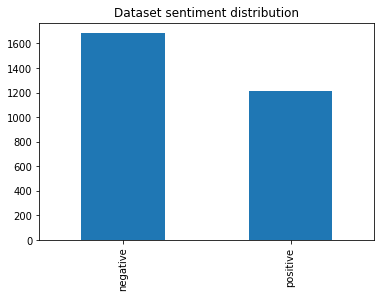

In [7]:
# Some Tokens are None which we must drop first
predictions.dropna(how='any', inplace=True)
# Some sentiment are 'na' which we must drop first
predictions = predictions[predictions.sentiment!= 'na']
predictions.sentiment.value_counts().plot.bar(title='Dataset sentiment distribution')

## 3.3 Checkout emotion distribution

In [8]:
predictions.emotion.value_counts().plot.bar(title='Dataset emotion category distribution')

AttributeError: ignored

# 4.Prepare data for T-SNE algorithm.
We create a Matrix with one row per Embedding vector for T-SNE algorithm

In [9]:
import numpy as np

# We first create a column of type np array
predictions['np_array'] = predictions.covidbert_embeddings.apply(lambda x: np.array(x))
# Make a matrix from the vectors in the np_array column via list comprehension
mat = np.matrix([x for x in predictions.np_array])
mat.shape

(2901, 1024)

## 4.1 Fit and transform T-SNE algorithm


In [10]:

from sklearn.manifold import TSNE
model = TSNE(n_components=2) #n_components means the lower dimension
low_dim_data = model.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (2901, 2)


### Set plotting styles

In [11]:
# set some styles for for Plotting
import seaborn as sns
# Style Plots a bit
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1,rc={"lines.linewidth": 2.5})

%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (20, 14)


# 6.1 Plot low dimensional T-SNE COVIDBERT embeddings with hue for POS


Text(0.5, 1.0, 'T-SNE COVIDBERT Embeddings, colored by Part of Speech Tag')

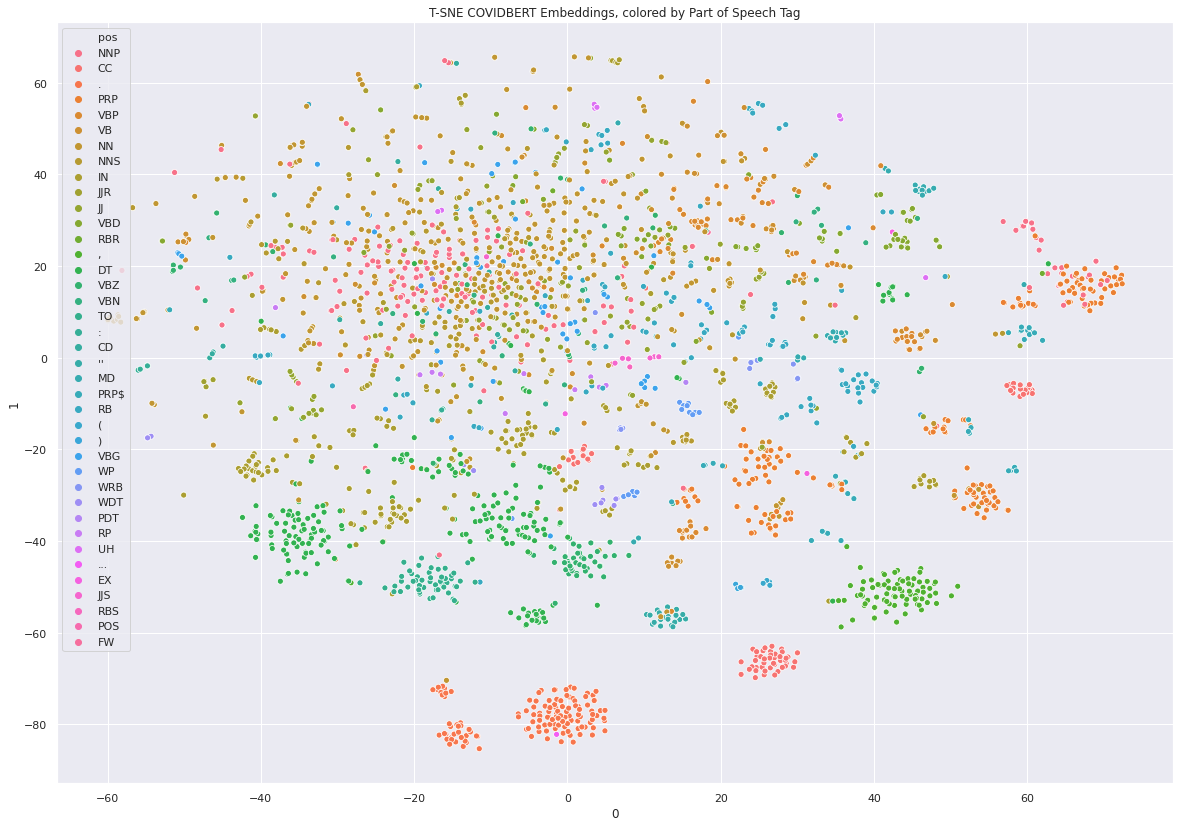

In [12]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.pos)
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE COVIDBERT Embeddings, colored by Part of Speech Tag')


##6.2 Plot low dimensional T-SNE COVIDBERT embeddings with hue for Sarcasm


Text(0.5, 1.0, 'T-SNE COVIDBERT Embeddings, colored by Sarcasm label')

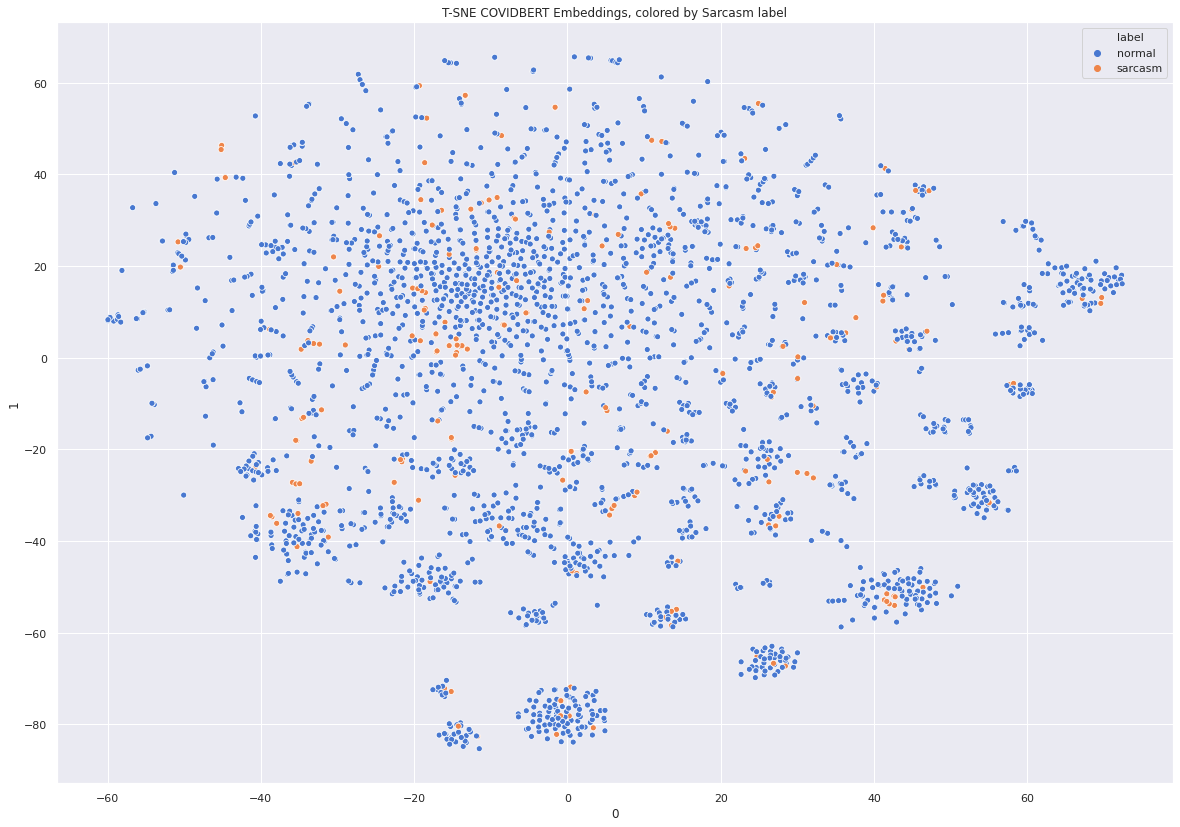

In [13]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.label.replace({1:'sarcasm',0:'normal'}))
ax = sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE COVIDBERT Embeddings, colored by Sarcasm label')


## 6.3 Plot low dimensional T-SNE COVIDBERT embeddings with hue for Sentiment


Text(0.5, 1.0, 'T-SNE COVIDBERT Embeddings, colored by Sentiment')

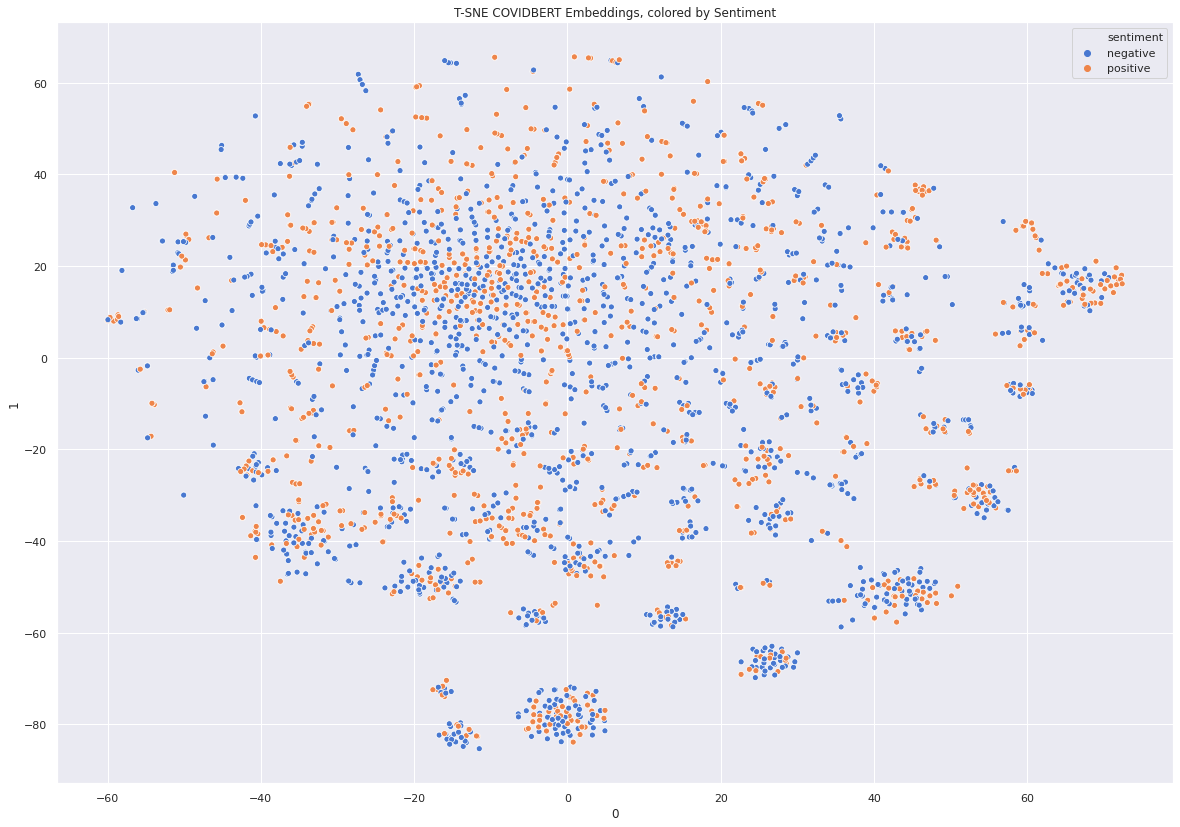

In [14]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.sentiment)
ax =  sns.scatterplot(data=tsne_df, x=0, y=1, hue=tsne_df.index)
ax.set_title('T-SNE COVIDBERT Embeddings, colored by Sentiment')


# 7. NLU has many more embedding models!      
Make sure to try them all out!       
You can change 'covidbert' in nlu.load('covidbert') to bert, xlnet, albert or any other of the **100+ word embeddings** offerd by NLU

In [16]:
nlu.print_all_model_kinds_for_action('embed')

For language <en> NLU provides the following Models : 
nlu.load('en.embed') returns Spark NLP model glove_100d
nlu.load('en.embed.glove') returns Spark NLP model glove_100d
nlu.load('en.embed.glove.100d') returns Spark NLP model glove_100d
nlu.load('en.embed.bert') returns Spark NLP model bert_base_uncased
nlu.load('en.embed.bert.base_uncased') returns Spark NLP model bert_base_uncased
nlu.load('en.embed.bert.base_cased') returns Spark NLP model bert_base_cased
nlu.load('en.embed.bert.large_uncased') returns Spark NLP model bert_large_uncased
nlu.load('en.embed.bert.large_cased') returns Spark NLP model bert_large_cased
nlu.load('en.embed.biobert') returns Spark NLP model biobert_pubmed_base_cased
nlu.load('en.embed.biobert.pubmed_base_cased') returns Spark NLP model biobert_pubmed_base_cased
nlu.load('en.embed.biobert.pubmed_large_cased') returns Spark NLP model biobert_pubmed_large_cased
nlu.load('en.embed.biobert.pmc_base_cased') returns Spark NLP model biobert_pmc_base_cased
nlu.lo